# Comparison of Optimization algorithms

I took last semester a course on optimization algorithms, where we prove how many steps does each algorithm need to converge to an epsilon error. However the course was pure theory and I would like to see if the  mathematical profs apply in practice.

The algorithms used in this notebook can be clustered as follows: <br>
<ol>
    <li> First order methods </li>
    <li> Second order and quasi newton methods</li>
    <li> Coordinate based methods </li>
    <li> Constrained optimization algorithms </li>
</ol>

The function we are going to work with is the least squares problem , which is widely used in ML. The function is characterized by :
$$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

where A is the data matrix and b is a bias vector

In [1]:
# imports
import numpy as np
from optimizers.firstOrder import First_Order_Optimizer
from optimizers.secondOrder import Second_Order_Optimizer
from optimizers.coordinate import Coordinate_Based_Optimizers
from optimizers.constrained import Constrained_Optimizers
from math import sqrt
import matplotlib.pyplot as plt

# DATA GENERATION

In [2]:
def generate_data_bias(num_points,features,lower_bound,upper_bound):
    '''
    random generation of data and bias
    '''
    A = np.random.uniform(lower_bound,upper_bound,(num_points,features))
    b = np.random.uniform(lower_bound,upper_bound,(num_points,1))
    return A,b

In [3]:
A,b = generate_data_bias(1000,1000,0,1)

In [4]:
print("Data matrix dimension = {} and bias vector dimension {}".format(A.shape,b.shape))

Data matrix dimension = (1000, 1000) and bias vector dimension (1000, 1)


# Function Properties

### Computing Smoothness

$f(x)$ is smooth with $L = \frac1n\|A\|^2$ 

In [5]:
def computing_function_smoothness(A):
    '''
    implementation of frobenius norm for matrices
    '''
    N = A.shape[0]
    eigen_values = np.linalg.eigvals(np.dot(A.T,A))
    maximum_eig = np.max(eigen_values)
    return (1/N) * maximum_eig

In [6]:
def coordinate_wise_smoothness(A):
    
    dim_smoothnes = np.zeros((A.shape[1]))
    for dim in range(0,A.shape[1]):
        dim_smoothnes[dim] = np.linalg.norm(A[:,dim],2)
    
    return dim_smoothnes

### Computing Lipshitz constant

Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top Ab\|)$

In [7]:
def lipshitz_gradient_constant(R,A,b):
    N = A.shape[0]
    lipshitz_cnst = (R * np.linalg.norm(np.dot(A.T,A),2)) + (np.linalg.norm(np.dot(np.dot(A.T,A),b),2))
    return 1/N * lipshitz_cnst

Another nice property of the least squares problem is that the function is also strongly convex with parameter $\mu = \lambda_{max}(\nabla^2 f(x))$

# Theoretical Analysis summary

## 1) BOUNDED GRADIENTS

Considering the following assumptions: $$ \|\nabla(x)\|^2 < L $$ and $$ \|x_0 - x^*\|^2 <R $$ 

where L is the lipshitz continuity constant of the least squares function and R is an upper bound on the distance between  the starting point and the optimum.For simplicity assume that R = 25. This yields the following theoretical results:

All gradient descent variants converge in  $$ \mathcal{O}(\frac{1}{\epsilon^2}) $$ steps , by setting the learning rate to $ \frac{R}{ L \sqrt{T} } $


## 2) Smoothness

Assuming that the gradient of the least squares problem is lipshitz continous (i.e function is smooth) and setting the learning rate to $ \frac{1}{L} $ , where L is the smoothness constant of the function $f$ , then :

1. Gradient descent variants converge in $ \mathcal{O}(\frac{1}{\epsilon}) $ steps.
2. Constrained Optimizers:
    *. Projected gradinet descent has the same analysis as gradient descent variants
    *. Frank Wolfe converges in $ \mathcal{O}(\frac{1}{\epsilon}) $ steps by setting the learning rate to $ \frac{2}{t + 2} $ , where t is the current iterate.

## 3) Strong convexity

In addition to the smoothness assumption , we also assume that the function is strongly convex with parameter $\mu$ we get the following results:
1. Gradient descent variants converge in $ \mathcal{O}( \log (\frac{1}{\epsilon}) ) $ steps.
2. Projected gradinet descent has the same analysis as gradient descent variants.
3. Coordinate based optimizers, with different coordinate selection strategies (random,importance sampling,steepest) , converge in $ \mathcal{O}( \log (\frac{1}{\epsilon}) ) $ steps.

## 4) Newton's method

Newton's method has a super log linear convergence result $ \mathcal{O}(\log \log (\frac{1}{\epsilon}) ) $. However this analysis can only be assumed if :
1. We are epsilon close from the optimum , through using any of gradient descent variants , then we switching to newton.
2. Hessians are lipshitz continous , with parameter $ L $
3. Invverse hessians are bounded , with parameter $ \mu $
4. $ \|x_0 - x^*\|^2 < \frac{\mu}{L} $ 

## 5) Nestrov ACG 

Convergence results can only be obtained by repeatedly restarting the algorithm. 
1. Smooth functions , with parameter $ L $, converges in $ \mathcal{O}(\frac{1}{\sqrt\epsilon}) $ steps.
2. Strongly convex functions , with parameter $ \mu $ converges in $ \mathcal{O}(\sqrt(\frac{L}{\mu})) $ steps.

# Plot functions

This section is intended to have plots that show how the loss evolves as the algorithm proceeds in iterations

In [8]:
def plot_loss(losses,iterations,legend,method_name):
    
    if legend is not None:
        for i  in range(0,len(legend)):
            plt.plot(iterations,losses[i],label =legend[i])
        plt.legend()
    else:
        plt.plot(iterations,losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(method_name + ' performance')
    plt.show()

# Model Parameters

In [9]:
epsilon = 0.0001
max_iters = 100
R = 25
B = lipshitz_gradient_constant(R,A,b)
L = computing_function_smoothness(A)
L_i = coordinate_wise_smoothness(A)

# GRADIENT DESCENT AND VARIANTS

In [10]:
# step size according to analysis
bounded_gradient_step_size = (R / (B * sqrt(max_iters)))
smoothness_step_size = 1/L *0.1
step_sizes = [bounded_gradient_step_size,smoothness_step_size]
print("Bounded step size = {} , Smoothness step size = {}".format(bounded_gradient_step_size,smoothness_step_size))

Bounded step size = 0.00024238846731221457 , Smoothness step size = 0.0003986407397066371


In [11]:
def run_gradient_descent_variants(step_sizes):
    batches = [1,100,A.shape[0]]
    models_loss = []
    for batch in batches:
        local_errors = []
        for gamma in step_sizes:
            sgdOptimizer = First_Order_Optimizer(batch_size=batch,epsilon=epsilon,learning_rate=gamma,smoothness=None,max_iters= max_iters)
            weight,losses = sgdOptimizer.mini_batch_stochastic_gradient_descent(A,b)
            local_errors.append(losses)
        models_loss.append(local_errors)
    return models_loss

In [12]:
models_loss = run_gradient_descent_variants(step_sizes)

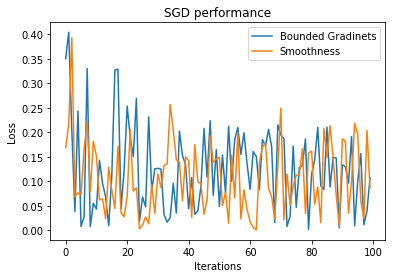

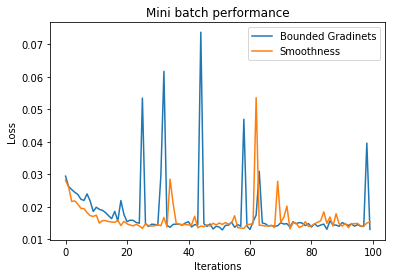

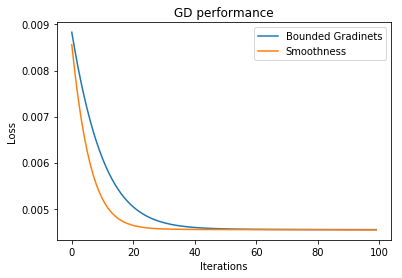

In [13]:
models_names = ['SGD','Mini batch','GD']
function_type = ['Bounded Gradinets','Smoothness']
for i in range(0,len(models_loss)):
    plot_loss(models_loss[i],np.arange(0,max_iters),function_type,models_names[i])

# NEWTONS METHOD

In [14]:
gamma = (1/L) * 0.1
newton = Second_Order_Optimizer(epsilon=epsilon,learning_rate=gamma,max_iters = 10)
weight,losses = newton.newtons_method(A,b)

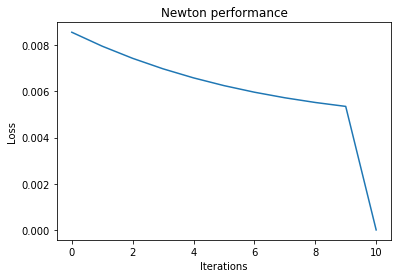

In [15]:
plot_loss(losses,np.arange(0,11),None,'Newton')

# COORDINATE DESCENT

In [16]:
gamma = (1 / L) * 0.1
strategies = ['random','importance','steep']
parameters = [None,L_i,None]
models_loss = []
for i in range(0,len(strategies)):
    coordOptimizer = Coordinate_Based_Optimizers(epsilon=epsilon,learning_rate=gamma,max_iters=max_iters) 
    _,losses = coordOptimizer.coordinate_descent(A,b,strategies[i],parameters[i])
    models_loss.append(losses)

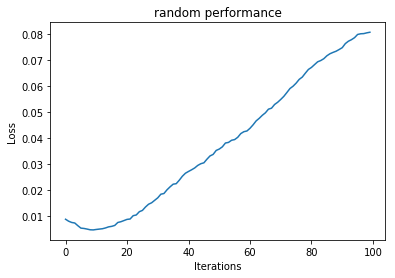

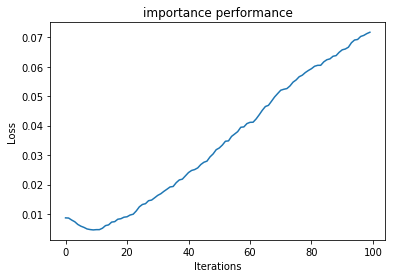

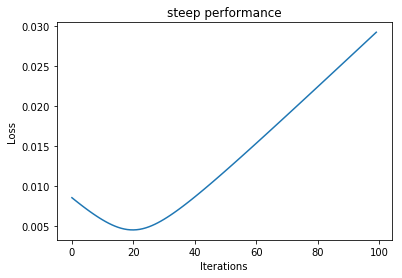

In [17]:
for i in range(0,len(strategies)):
    plot_loss(models_loss[i],np.arange(0,max_iters),None,strategies[i])

# Constrained Optimizers

The constrained set considered is the LASSO simplex. 

In [18]:
gamma = (1 / L) * 0.00001
constOptimizer = Constrained_Optimizers(epsilon=epsilon,learning_rate=gamma,max_iters=max_iters)

In [19]:
weight,losses = constOptimizer.projected_gradient_descent(A,b)

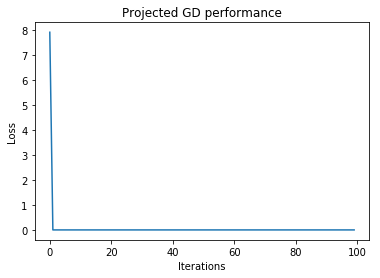

In [20]:
plot_loss(losses,np.arange(0,max_iters),None,'Projected GD')

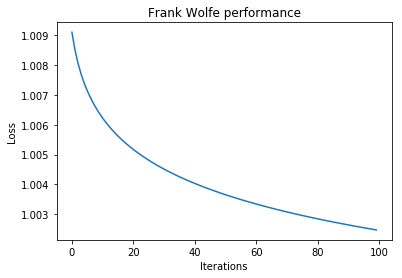

In [21]:
weight,losses = constOptimizer.frank_wolfe(A,b)
plot_loss(losses,np.arange(0,max_iters),None,'Frank Wolfe')

# Accelerated methods

In [22]:
gamma = (R/ sqrt(A.shape[1] * L)) * 0.01

In [23]:
nestrovOptmizer = First_Order_Optimizer(batch_size=A.shape[0],epsilon=epsilon,learning_rate=gamma,smoothness=L,max_iters= max_iters)
weight,losses = nestrovOptmizer.nestrov_accelerated_gradient_descent(A,b)#models_loss.append(losses

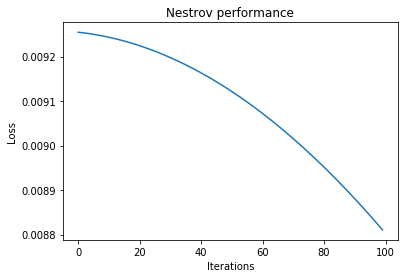

In [24]:
plot_loss(losses,np.arange(0,max_iters),None,'Nestrov')